# Building and Analyzing a Knowledge Graph from Movie Data 

## 1.Design a Knowledge Graph Model 

In [2]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

In [3]:
import pandas as pd

query = """
MATCH (m:Movie)
RETURN m.title AS title
LIMIT 10
"""
df = graph.run(query).to_data_frame()
df.head()

,title
0,The Lift
1,Adit Sopo Jarwo: The Movie
2,Deadly Illusions
3,9 fugas
4,"Hurrah, We Are Still Alive!"


In [4]:
import pandas as pd

query = """
MATCH (m:Actor)
RETURN m.name AS name
LIMIT 10
"""
df = graph.run(query).to_data_frame()
df.head()

,name
0,Fred Astaire
1,Lauren Bacall
2,Brigitte Bardot
3,John Belushi
4,Ingmar Bergman


In [5]:
import networkx as nx
import matplotlib.pyplot as plt

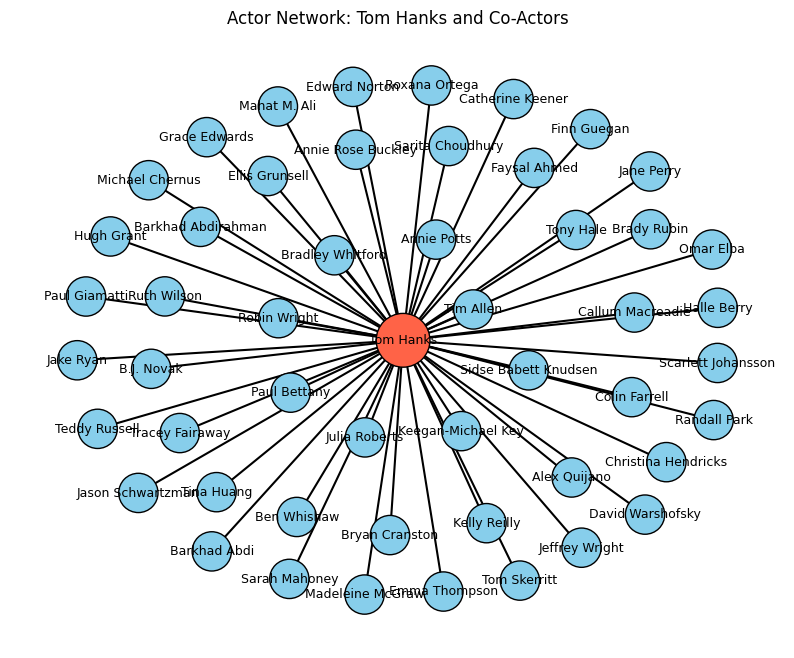

In [6]:
# Cypher query to get co-actors and number of shared movies
query = f"""
MATCH (p1:Person {{name: 'Tom Hanks'}})-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
RETURN p1.name AS source, p2.name AS target, count(m) AS weight
LIMIT 50
"""
df = graph.run(query).to_data_frame()

# Create graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight"])

# Visualize
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
node_colors = ["tomato" if n == 'Tom Hanks' else "skyblue" for n in G.nodes()]
node_sizes = [1500 if n == 'Tom Hanks' else 800 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors="black")
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title(f"Actor Network: {'Tom Hanks'} and Co-Actors")
plt.axis('off')
plt.show()

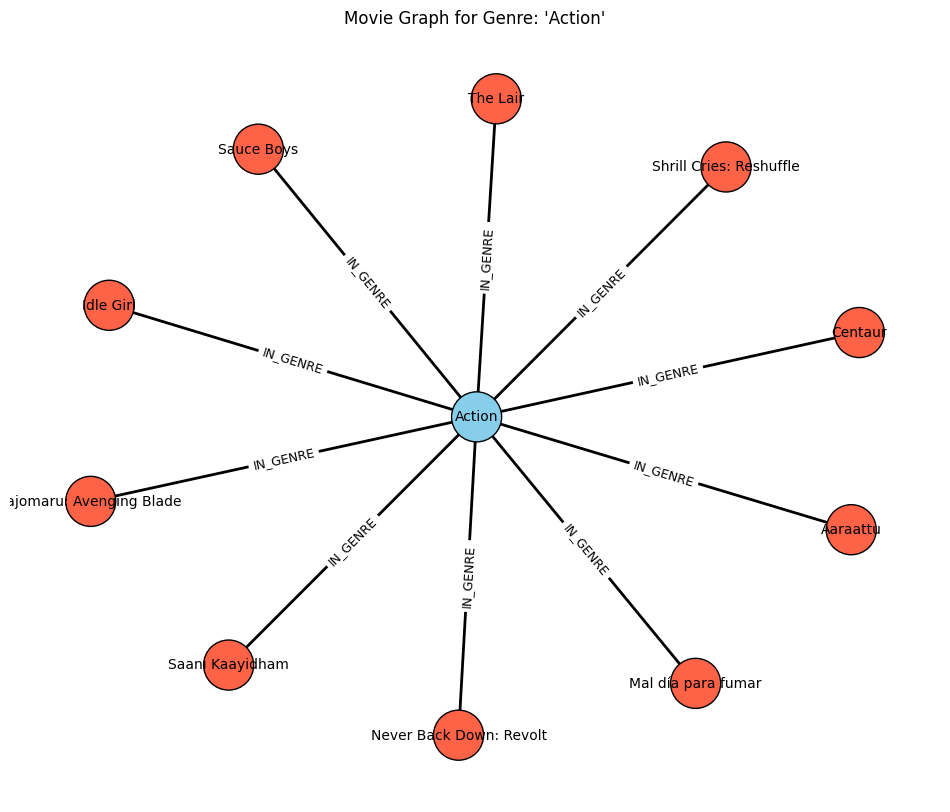

In [8]:
# Define the genre you want to visualize
genre = "Action"  # <-- Replace with any genre in your graph

# Query: Get movies in the given genre and their connected nodes (e.g., actors, directors)
query = f"""
MATCH (m:Movie)-[r]->(n:Genre)
WHERE n.name = 'Action'
RETURN m.title AS movie,
       type(r) AS relationship,
       labels(n)[0] AS node_label,
       coalesce(n.name, n.title) AS node_name
LIMIT 10
"""
df = graph.run(query).to_data_frame()

# Check if data returned
if df.empty:
    print(f"No connected nodes found for movies in the genre '{genre}'. Check if it exists in the database.")
else:
    # Create the graph
    G = nx.Graph()
    
    # Add the movies and their connected nodes
    for _, row in df.iterrows():
        movie = row["movie"]
        target = row["node_name"]
        rel = row["relationship"]
        label = row["node_label"]
        
        # Add nodes for movies and related entities
        G.add_node(movie, label="Movie", color="tomato")
        G.add_node(target, label=label, color="skyblue")
        G.add_edge(movie, target, label=rel)

    # Layout and draw
    pos = nx.spring_layout(G, k=0.5)
    node_colors = [G.nodes[n]["color"] for n in G.nodes()]
    plt.figure(figsize=(12, 10))

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1300, edgecolors="black")
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(f"Movie Graph for Genre: '{genre}'")
    plt.axis("off")
    plt.show()


## 2.Query and Explore the Graph using Cypher 

### genre based gropuing

In [9]:
query = """
MATCH (g:Genre)<-[r]-(m:Movie)
RETURN g.name AS Genre, count(m) AS MovieCount
ORDER BY MovieCount DESC
LIMIT 10
"""

# Execute the query and convert the result to a DataFrame
df = graph.run(query).to_data_frame()

# Display the DataFrame
df

,Genre,MovieCount
0,Drama,143482
1,Comedy,77170
2,Romance,35576
3,Action,32824
4,Crime,27615
5,Thriller,27303
6,Horror,24427
7,Adventure,18703
8,Mystery,12754
9,Family,11670


### Directors who have directed the most films:

In [10]:
query = """
MATCH (p:Person)-[r:DIRECTED]->(m:Movie)
RETURN p.name as Director, count(m) as MovieCount
ORDER BY MovieCount DESC
LIMIT 10
"""

# Execute the query and convert the result to a DataFrame
df = graph.run(query).to_data_frame()

# Display the DataFrame
df

,Director,MovieCount
0,Sam Newfield,201
1,Jesús Franco,167
2,Gilberto Martínez Solares,146
3,William Beaudine,143
4,Richard Thorpe,133
5,Osman F. Seden,131
6,Lesley Selander,131
7,Ray Taylor,124
8,Lambert Hillyer,122
9,Godfrey Ho,119


### degree disrubution of persons

In [11]:
# Define the query to find the top 10 people with the highest degree
query = """
MATCH (p:Person)-[r]-() 
RETURN p.name AS name, COUNT(r) AS degree 
ORDER BY degree DESC 
LIMIT 10
"""

# Execute the query and convert the result to a DataFrame
df = graph.run(query).to_data_frame()

# Display the DataFrame
df

,name,degree
0,Brahmanandam,698
1,Shakti Kapoor,387
2,Jagathy Sreekumar,365
3,Eric Roberts,353
4,Mammootty,339
5,Ron Jeremy,337
6,Mithun Chakraborty,336
7,Cüneyt Arkin,324
8,Nassar,321
9,Mohanlal,315


### degree disrubution of movies

In [12]:
# Define the query to find the top 10 movies with the highest degree
query = """
MATCH (m:Movie)-[r]-() 
RETURN m.title AS title, COUNT(r) AS degree 
ORDER BY degree DESC 
LIMIT 10
"""

# Execute the query and convert the result to a DataFrame
df = graph.run(query).to_data_frame()

# Display the DataFrame
df

,title,degree
0,The Shawshank Redemption,103371
1,Forrest Gump,100544
2,Pulp Fiction,98890
3,The Matrix,94139
4,The Silence of the Lambs,90678
5,Fight Club,77670
6,Jurassic Park,75616
7,Schindler's List,74242
8,The Lord of the Rings: The Fellowship of the Ring,73451
9,Braveheart,70016


### pagerank centrality of persons ( a part of persons )

In [13]:
graph.run("""
CALL gds.graph.project.cypher(
  'actorGraph',
  '
  MATCH (p:Person)
  RETURN id(p) AS id
  LIMIT 10000
  ',
  '
  MATCH (p1:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
  WHERE id(p1) < id(p2)
  RETURN id(p1) AS source, id(p2) AS target
  '
  ,
  {
    validateRelationships: false
  }
)
""")

nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,projectMillis
MATCH (p:Person) RETURN id(p) AS id LIMIT 10000,"MATCH (p1:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person) WHERE id(p1) < id(p2) RETURN id(p1) AS source, id(p2) AS target",actorGraph,10000,84496,3195


In [21]:
centrality_result = graph.run("""
    CALL gds.pageRank.stream('actorGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS actor, score
    ORDER BY score DESC LIMIT 10
""")

pagerank_df = pd.DataFrame(centrality_result.data())

pagerank_df

,actor,score
0,Vikas Anand,6.571840
1,Donal Logue,5.269336
2,Anthony Anderson,4.808187
3,Owen Wilson,4.788707
4,Amy Adams,4.744190
5,David Alexander,4.313654
6,Malin Akerman,4.264783
7,Saul Rubinek,4.251555
8,Luke Wilson,4.139141
9,Elizabeth Banks,3.852949
